In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

# Local imports
from model import GraphAttentionNetwork
from utils.dataset import DrugProteinDataset
from utils.helper_functions import set_seeds, accuracy_func, plot_loss_curves

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [3]:
def train_model(args) -> None:
    set_seeds()

    model = GraphAttentionNetwork(
        333, 1, 16,
        args['hidden_size'],
        args['num_layers'],
        args['num_attn_heads']
    ).to(device)

    train_dataset, validation_dataset, test_dataset = load_data(
        args['data_path'], args['seed'],
        args['frac_train'], args['frac_validation'], args['frac_test'],
        args['use_small_dataset']
    )
    
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=args['batch_size'], shuffle=False)

    loss_func = nn.SmoothL1Loss(beta=args['huber_beta'])
    optimizer = optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args['scheduler_factor'], patience=args['scheduler_patience'])

    best_validation_loss = float('inf')
    no_validation_loss_improvement = 0
    metrics_df = pd.DataFrame(columns=['train_loss', 'validation_loss'], index=range(args['max_epochs']))

    for epoch in range(args['max_epochs']):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{args['max_epochs']}", leave=True)
        avg_train_loss, avg_train_acc = run_training_epoch(progress_bar, optimizer, model, loss_func)
        avg_validation_loss, avg_validation_acc = get_validation_metrics(validation_loader, model, loss_func)

        lr_scheduler.step(avg_train_loss)

        metrics_df.at[epoch, 'train_loss'] = avg_train_loss
        metrics_df.at[epoch, 'validation_loss'] = avg_validation_loss
        metrics_df.at[epoch, 'train_acc'] = avg_train_acc
        metrics_df.at[epoch, 'validation_acc'] = avg_validation_acc

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.5f}, Validation Loss = {avg_validation_loss:.5f}, "
              f"Train Acc = {avg_train_acc:.5f}, Validation Acc = {avg_validation_acc:.5f}")

        if avg_validation_loss < best_validation_loss:
            best_validation_loss = avg_validation_loss
            no_validation_loss_improvement = 0
            torch.save(model.state_dict(), '../models/model.pth')
        else:
            no_validation_loss_improvement += 1
            if no_validation_loss_improvement == args['stoppage_epochs']:
                break

    plot_loss_curves(metrics_df)


In [4]:
def run_training_epoch(progress_bar, optimizer, model, loss_func):
    model.train()
    cum_samples = cum_loss = cum_acc = 0

    for batch_data in progress_bar:
        node_features, edge_features, adjacency_matrix, pchembl_score = [
            x.to(torch.float32).to(device) for x in batch_data
        ]

        preds = model(node_features, edge_features, adjacency_matrix).squeeze(-1)
        loss = loss_func(preds, pchembl_score)

        cum_samples += preds.shape[0]
        cum_loss += loss.item() * preds.shape[0]
        cum_acc += accuracy_func(preds, pchembl_score, threshold=7.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return cum_loss / cum_samples, cum_acc / cum_samples


In [5]:
def get_validation_metrics(loader, model, loss_func):
    model.eval()
    cum_samples = cum_loss = cum_acc = 0

    for batch in loader:
        node_features, edge_features, adjacency_matrix, pchembl_scores = [
            x.to(torch.float32).to(device) for x in batch
        ]

        preds = model(node_features, edge_features, adjacency_matrix).squeeze(-1)
        loss = loss_func(preds, pchembl_scores).item()
        acc = accuracy_func(preds, pchembl_scores, threshold=7.0)

        cum_samples += preds.shape[0]
        cum_loss += loss * preds.shape[0]
        cum_acc += acc

    return cum_loss / cum_samples, cum_acc / cum_samples


In [6]:
def load_data(data_path, seed, frac_train, frac_val, frac_test, use_small):
    assert math.isclose(frac_train + frac_val + frac_test, 1), "Splits must sum to 1"

    file_name = 'filtered_cancer_small.csv' if use_small else 'filtered_cancer_all.csv'
    data_df = pd.read_csv(f'{data_path}/{file_name}')
    protein_df = pd.read_csv(f'{data_path}/protein_embeddings.csv', index_col=0)

    data_df['stratify_col'] = data_df['Target_ID'] + '_' + data_df['label'].astype(str)

    train_df, remain_df = train_test_split(data_df, test_size=frac_val + frac_test,
                                           stratify=data_df['stratify_col'], random_state=seed)
    val_df, test_df = train_test_split(remain_df, test_size=frac_test / (frac_val + frac_test),
                                       stratify=remain_df['stratify_col'], random_state=seed)

    train_df = train_df.drop(columns='stratify_col')
    val_df = val_df.drop(columns='stratify_col')
    test_df = test_df.drop(columns='stratify_col')

    train_set = DrugProteinDataset(train_df, protein_df)
    val_set = DrugProteinDataset(val_df, protein_df)
    test_set = DrugProteinDataset(test_df, protein_df)

    return train_set, val_set, test_set


In [ ]:
args = {
    "use_small_dataset": True,
    "batch_size": 64,
    "stoppage_epochs": 128,
    "max_epochs": 128,
    "seed": 42,
    "data_path": "../data",
    "frac_train": 0.7,
    "frac_validation": 0.15,
    "frac_test": 0.15,
    "huber_beta": 1.0,
    "weight_decay": 1e-4,
    "lr": 3e-3,
    "scheduler_patience": 10,
    "scheduler_factor": 0.5,
    "hidden_size": 32,
    "num_layers": 4,
    "num_attn_heads": 8,
    "dropout": 0.2,
    "leaky_relu_slope": 0.2
}


Epoch 1/128: 100%|██████████| 55/55 [00:05<00:00,  9.43it/s]


Epoch 1: Train Loss = 1.68656, Validation Loss = 0.62591, Train Acc = 0.65623, Validation Acc = 0.66534


Epoch 2/128: 100%|██████████| 55/55 [00:05<00:00,  9.93it/s]


Epoch 2: Train Loss = 0.62260, Validation Loss = 0.62541, Train Acc = 0.66392, Validation Acc = 0.66534


Epoch 3/128: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]


Epoch 3: Train Loss = 0.61629, Validation Loss = 0.63912, Train Acc = 0.66392, Validation Acc = 0.66534


Epoch 4/128: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]


Epoch 4: Train Loss = 0.61649, Validation Loss = 0.66694, Train Acc = 0.66448, Validation Acc = 0.66534


Epoch 5/128: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]


Epoch 5: Train Loss = 0.61098, Validation Loss = 0.62712, Train Acc = 0.66249, Validation Acc = 0.66534


Epoch 6/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 6: Train Loss = 0.61038, Validation Loss = 0.66856, Train Acc = 0.66135, Validation Acc = 0.66534


Epoch 7/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 7: Train Loss = 0.60422, Validation Loss = 0.65093, Train Acc = 0.66505, Validation Acc = 0.66534


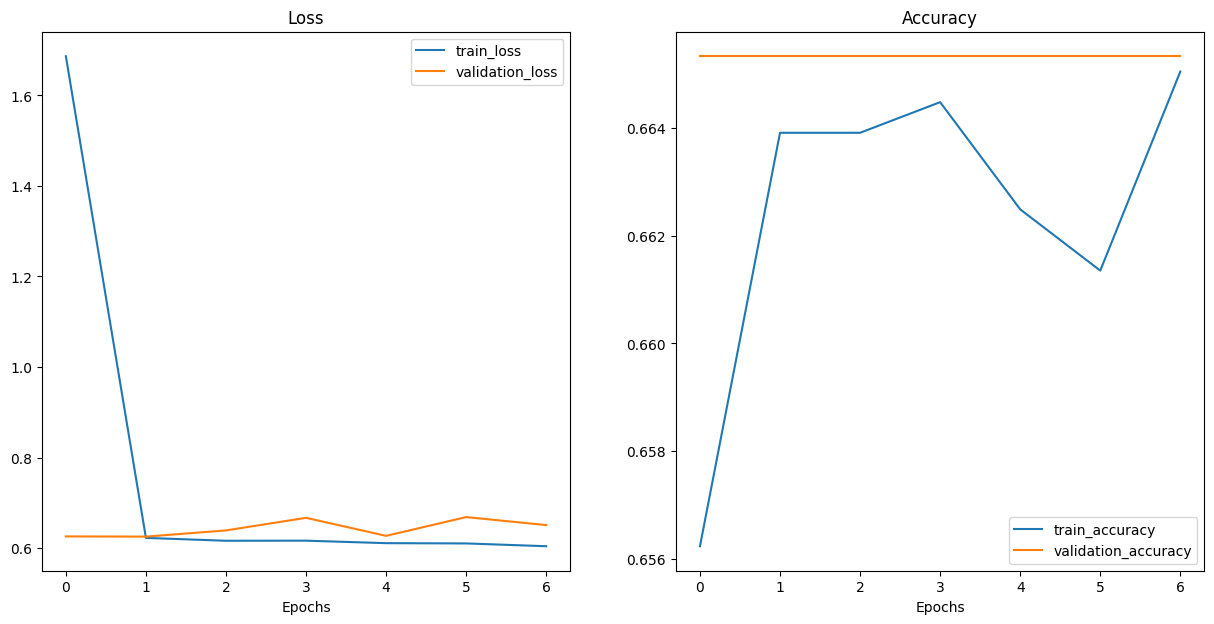

In [9]:
train_model(args)
